In [1]:
import pandas as pd
import json
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from ipynb.fs.full.common import *



In [2]:
gameplays = pd.json_normalize(pd.Series(open(r"C:\Users\Yasmine Bogaert\Documents\thesis\dump\dump_30-03-2021\csv\gameplays.json").readlines()).apply(json.loads))

In [3]:
gameplays = preprocess_gameplays(gameplays)

In [4]:
gameplays = add_distance_per_jump(gameplays)

In [5]:
# umap needs numeric values
gameplays = convert_collisionObstacle_numeric(gameplays)

In [6]:
# load questionresponses and expand the response columns to contain "lastentry" and "secondlastentry" instead of 'A', 'B' or 'BOTH'
questionresponses = pd.json_normalize(pd.Series(open(r"C:\Users\Yasmine Bogaert\Documents\thesis\dump\dump_30-03-2021\csv\questionresponses.json").readlines()).apply(json.loads))
questionresponses = drop_duplicates_questionresponses(questionresponses)
questionresponses = expand_questionresponses(questionresponses)

In [7]:
gameplays.columns


Index(['UUID', 'events', 'logs', 'obstacles', 'nr_jumps', 'playIntro',
       'newHighScore', 'distanceRan', 'actualDistance', 'invertedGameOver',
       'obstacleTypes', 'gameOverTime', 'gameOverScreen', 'dateTime', 'USERID',
       '_id.$oid', 'collisionObstacle.typeConfig.type',
       'collisionObstacle.typeConfig.width',
       'collisionObstacle.typeConfig.height',
       'collisionObstacle.typeConfig.yPos',
       'collisionObstacle.typeConfig.multipleSpeed',
       'collisionObstacle.typeConfig.minGap',
       'collisionObstacle.typeConfig.minSpeed',
       'collisionObstacle.typeConfig.collisionBoxes',
       'collisionObstacle.dimensions.WIDTH',
       'collisionObstacle.dimensions.HEIGHT', 'collisionObstacle.size',
       'collisionObstacle.width', 'collisionObstacle.xPos',
       'collisionObstacle.yPos', 'collisionObstacle.collisionBoxes',
       'collisionObstacle.speedOffset', 'collisionObstacle.gap',
       'runnerConfig.ACCELERATION', 'runnerConfig.BG_CLOUD_SPEED',
   

In [8]:
useful_gameplays, useful_questionresponses = filter_useful_gameplays_questionresponses(gameplays, questionresponses)

C:\Users\Yasmine Bogaert\Documents\thesis\common.ipynb:198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "# get all the id's that occur in questionresponses as a list\n",


In [9]:
useful_gameplays.shape

(704, 88)

In [10]:
ev = get_evaluated_entries(useful_questionresponses)
len(ev)

704

In [11]:
# fit umap on game data
relevant_parameters = parameters + ['distance_per_jump']
game_data = useful_gameplays[parameters].values
u = umap_fit(game_data)

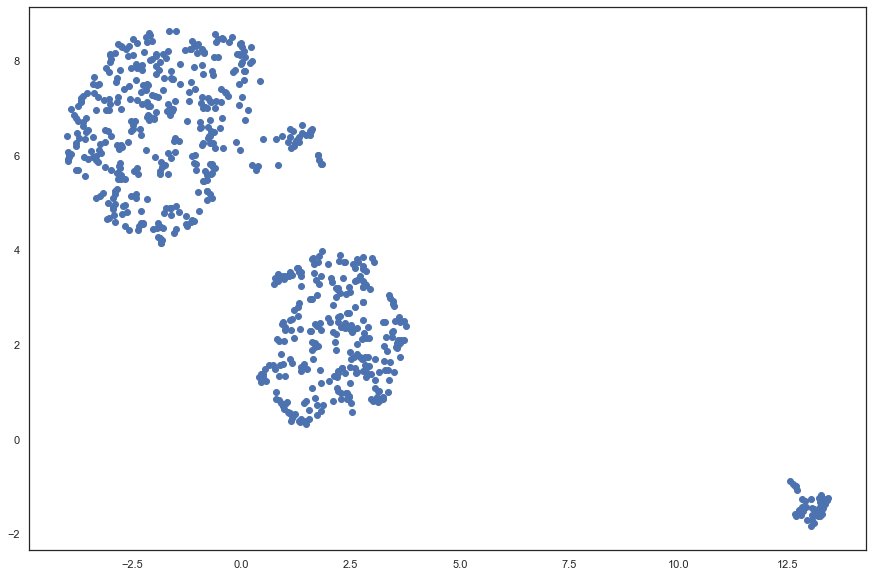

In [12]:
# default scatter, no color
sns.set(style='white', context='notebook', rc={'figure.figsize':(15,10)})
plt.scatter(u[:,0], u[:,1])

In [13]:
def evaluation_score(questionresponses, gameplays, parameter):
    exploded = explode_questionresponses(questionresponses, gameplays)
    evaluation = exploded[['entry', parameter]].groupby('entry').mean()
    return evaluation[parameter]

ev = evaluation_score(useful_questionresponses, useful_gameplays, 'challenging')

In [21]:
def scatter_umap_color(fit, title='umap scatter', color_values = None, color_map = None, color_norm = None, ax=None):
    if ax is not None:
        p = ax.scatter(fit[:,0], fit[:,1], c = color_values, cmap=color_map, norm=color_norm)
        fig.colorbar(p, ax = ax)
        ax.title.set_text(title) 
    else:
        plt.figure()
        p = plt.scatter(fit[:,0], fit[:,1], c = color_values, cmap=color_map, norm=color_norm)
        plt.colorbar(p)
        plt.title(title)


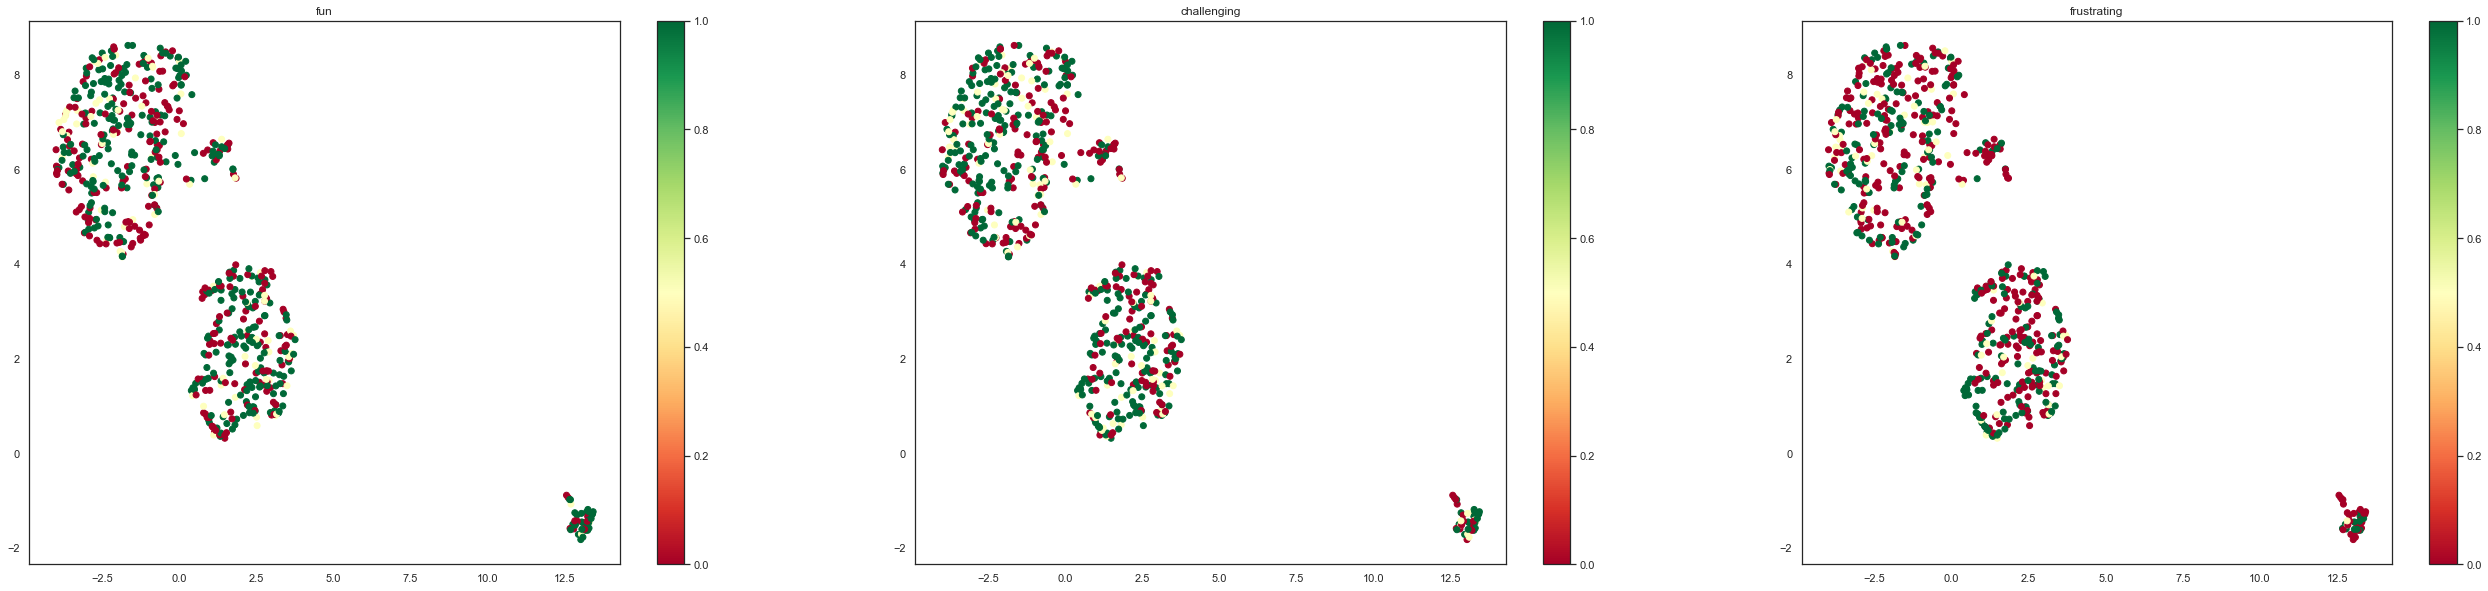

In [22]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(45,10)})
fig, ax_array = plt.subplots(1, 3) 
for i, column in enumerate(columns):
    ax = ax_array[i]
    color_values = evaluation_score(useful_questionresponses, useful_gameplays, column)
    scatter_umap_color(u, title=column, color_values=color_values, color_map=plt.get_cmap('RdYlGn'), ax = ax)
plt.savefig('graphs/notebook/umap/umap_gameplays_colored.png')

In [15]:
# restrict gameplays to the ones that were also evaluated in questionresponses
